### TESTE COM LINEAR REGRESSION

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


OUTPUT_FILE = "dataset_final_4_clusters.csv" 
TARGET_COLUMN = 'consumo_gwh'


df = pd.read_csv(OUTPUT_FILE, sep=';')


df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')


feature_cols = [
    'dow', 
    'is_weekend', 
    'month', 
    'year', 
    'day_length_hours',
    'HDD18_Cluster0', 
    'HDD18_Cluster1', 
    'HDD18_Cluster2', 
    'HDD18_Cluster3'
]


X = df[feature_cols]
y = df[TARGET_COLUMN]


test_size = 0.15 
split_point = int(len(df) * (1 - test_size))

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Dataset de Treino: {len(X_train)} dias ({X_train.index.min().date()} a {X_train.index.max().date()})")
print(f"Dataset de Teste: {len(X_test)} dias ({X_test.index.min().date()} a {X_test.index.max().date()})")

Train dataset: 3337 days (2015-01-01 a 2024-02-19)
Test dataset: 589 days (2024-02-20 a 2025-09-30)


In [3]:

rlm = LinearRegression()
rlm.fit(X_train, y_train)


y_pred_rlm = rlm.predict(X_test)


r2_rlm = r2_score(y_test, y_pred_rlm)


rmse_rlm = np.sqrt(mean_squared_error(y_test, y_pred_rlm))


mae_rlm = mean_absolute_error(y_test, y_pred_rlm)


mape_rlm = np.mean(np.abs((y_test - y_pred_rlm) / y_test)) * 100

print("\n" + "="*50)
print("       RESULTS: MULTIPLE LINEAR REGRESSION")
print("="*50)
print(f"R² (Coef. de Determinação): {r2_rlm:.4f}")
print(f"RMSE (Erro Quadrático Médio): {rmse_rlm:.2f} GWh")
print(f"MAE (Erro Absoluto Médio): {mae_rlm:.2f} GWh")
print(f"MAPE (Erro Percentual Médio): {mape_rlm:.2f} %")
print("-" * 50)


       RESULTS: MULTIPLE LINEAR REGRESSION
R² (Coef. of Determination): 0.6343
RMSE (Mean Square Error): 481.33 GWh
MAE (Mean Absolute Error): 362.41 GWh
MAPE (Average Percentage Error): 4.81 %
--------------------------------------------------


## TESTE COM XGBOOST


[INFO] A treinar o modelo XGBoost...

         RESULTADOS: XGBOOST REGRESSOR
R² (Coef. of Determination): 0.7083
RMSE (Mean Square Error): 429.88 GWh
MAE (Mean Absolute Error): 320.67 GWh
MAPE (Average Percentage Error): 4.21 %
--------------------------------------------------

     IMPORTANCE OF VARIABLES (XGBOOST)
dow                 0.413662
HDD18_Cluster0      0.205888
month               0.162568
day_length_hours    0.064781
HDD18_Cluster1      0.058605
year                0.042598
HDD18_Cluster3      0.029585
HDD18_Cluster2      0.022313
is_weekend          0.000000
dtype: float32
--------------------------------------------------


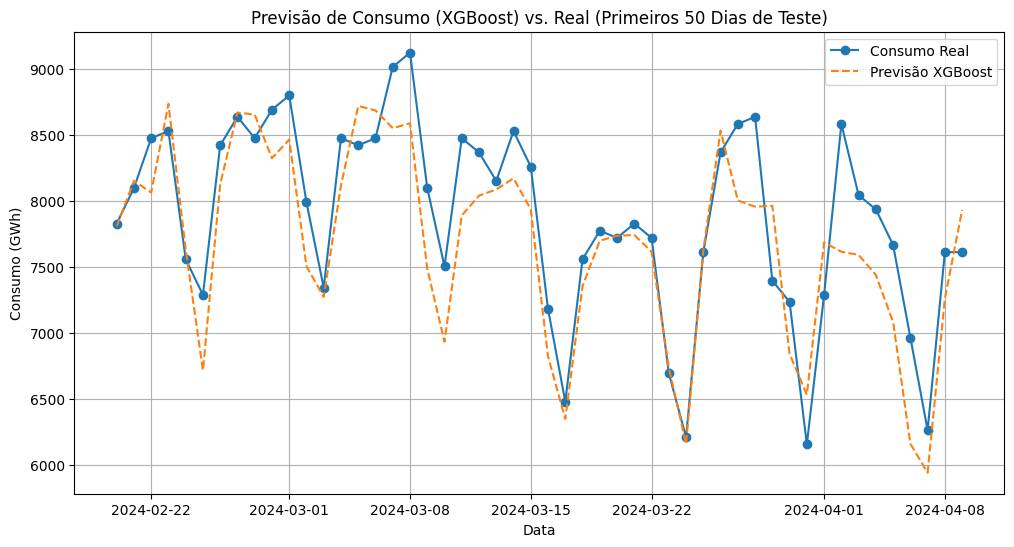

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor 
import matplotlib.pyplot as plt


OUTPUT_FILE = "dataset_final_4_clusters.csv"
TARGET_COLUMN = 'consumo_gwh'


df = pd.read_csv(OUTPUT_FILE, sep=';')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

feature_cols = [
    'dow', 
    'is_weekend', 
    'month', 
    'year', 
    'day_length_hours',
    'HDD18_Cluster0', 
    'HDD18_Cluster1', 
    'HDD18_Cluster2', 
    'HDD18_Cluster3'
]

X = df[feature_cols]
y = df[TARGET_COLUMN]


test_size = 0.15 
split_point = int(len(df) * (1 - test_size))

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]



print("\n[INFO] Training model XGBoost...")

xgb = XGBRegressor(
    n_estimators=150, # Nr. trees
    learning_rate=0.1, # Learning rate
    random_state=42,
    n_jobs=-1, 
    objective='reg:squarederror'
)
# Training model
xgb.fit(X_train, y_train)

# --- 3. Forecasts and Assessment ---
y_pred_xgb = xgb.predict(X_test)

# Metric 1: R-Squared (R²)
r2_xgb = r2_score(y_test, y_pred_xgb)

# Metric 2: Root Mean Squared Error (RMSE)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Metric 3: Mean Absolute Error (MAE)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

# Metric 4: Percentual (MAPE)
# We added a small epsilon to avoid division by zero, if applicable.
epsilon = 1e-10 
mape_xgb = np.mean(np.abs((y_test - y_pred_xgb) / (y_test + epsilon))) * 100

print("\n" + "="*50)
print("         RESULTS: XGBOOST REGRESSOR")
print("="*50)
print(f"R² (Coef. of Determination): {r2_xgb:.4f}")
print(f"RMSE (Mean Square Error): {rmse_xgb:.2f} GWh")
print(f"MAE (Mean Absolute Error): {mae_xgb:.2f} GWh")
print(f"MAPE (Average Percentage Error): {mape_xgb:.2f} %")
print("-" * 50)

# --- 4. Feature Importance ---
importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

print("\n" + "="*50)
print("     IMPORTANCE OF VARIABLES (XGBOOST)")
print("="*50)
print(importances)
print("-" * 50)

# Optional: View Forecasts vs. Actual (only the first N forecasts)
N = 50 
plt.figure(figsize=(12, 6))
plt.plot(y_test.index[:N], y_test.values[:N], label='Actual Consumption', marker='o')
plt.plot(y_test.index[:N], y_pred_xgb[:N], label='Forecast XGBoost', linestyle='--')
plt.title('Consumption Forecast (XGBoost) vs. Actual (First 50 Days of Testing)')
plt.xlabel('Date')
plt.ylabel('Consumption (GWh)')
plt.legend()
plt.grid(True)
plt.show()